In [12]:

import numpy as np
import matplotlib.pyplot as plt
import h5py

import PSID
# from PSID.evaluation import evalPrediction
# from PSID.MatHelper import loadmat

from lfads_torch.metrics import r2_score
from paper.plot_helpers import class_accuracy

def eval_model(data,predictions,mask=None):
  if mask is None:
    mask = np.ones(data['valid_behavior'][:].shape[0],dtype=bool)

  # PSID_R2 = evalPrediction(data['valid_behavior'][:][mask].reshape((-1,2)), predictions[mask].reshape(-1,2), 'R2').mean()

  directions = data['valid_target_direction']
  unique_dirs = sorted(set(directions))

  R2 = np.empty((len(unique_dirs))) # directions
  for i,d in enumerate(unique_dirs):
    precision_error = (predictions[mask & (directions==d)] - data['valid_behavior'][:][mask & (directions==d)])**2
    total_variance = (data['valid_behavior'][:][mask & (directions==d)] - data['valid_behavior'][:][mask & (directions==d)].mean(0))**2+1e-6
    R2[i] = 1 - precision_error.sum()/total_variance.sum() # sum over trials and time and space
  R_UIVE = R2.mean() #uninstructed variance explained

  precision_error = (predictions[mask] - data['valid_behavior'][:][mask])**2
  total_variance = (data['valid_behavior'][:][mask] - data['valid_behavior'][:][mask].mean(0))**2
  vec_R2 = 1 - precision_error.sum()/total_variance.sum() # sum over trials and time and space
  return vec_R2,R_UIVE

In [2]:
tT = 200 # ms target oscillatory frequency
dt = 100 # ms range
oscillatory_criterion = lambda a: (a > 2 * 10 * np.pi/(tT+dt)) & (a < 2 * 10 * np.pi/(tT-dt))


def plot_eigenspectrum(A, ax=None):

    if ax is None:
        _, ax = plt.subplots(1,1)

    evals, _ = np.linalg.eig(A)

    ax.plot([-1,1],[0,0],'k')
    ax.plot([0,0],[-1,1],'k')
    eigen_colors = []
    cc = 0 # color counter
    for e in evals:
        if e.imag >= 0: # plot conjugate pairs in the same color
            ax.plot(e.real,e.imag,'o',color='C'+str(cc))
            eigen_colors.append('C'+str(cc))
            if e.imag > 0:
                ax.plot(e.real,-e.imag,'o',color='C'+str(cc))
                eigen_colors.append('C'+str(cc))
            cc += 1
    # draw a line at 18 degrees
    for t in [tT-dt, tT, tT+dt]:
        tan = np.tan(2 * 10 * np.pi/t)
        style = 'k--' if t == tT else 'r--'
        ax.plot([0,np.sqrt(1-tan**2)],[0,tan],style)
        ax.plot([0,np.sqrt(1-tan**2)],[0,-tan],style)
    # draw a unit circle
    x = np.linspace(-1,1,100)
    y = np.sqrt(1-x**2)
    ax.plot(x,y,'k')
    y = -np.sqrt(1-x**2)
    ax.plot(x,y,'k')

    ax.axis('equal')
    # remove frame and ticks
    ax.axis('off')
    return eigen_colors

def plot_model_summary(model):
    _, ax = plt.subplots(1,3,figsize=(8,3))
    eigen_colors = plot_eigenspectrum(model.A, ax=ax[0])
    _, evecs = np.linalg.eig(model.A)
    ax[1].imshow(model.A, vmin=0, vmax=1)
    m = ax[2].imshow(evecs.real, vmin=0, vmax=1)
    n = model.A.shape[0]
    plt.xticks(np.arange(n),['⚫' for _ in range(n)])
    plt.yticks(np.arange(n),['⚫' for _ in range(n)])

    ax[0].set_title('Eigenvalues')
    ax[1].set_title('A matrix')
    ax[2].set_title('Eigenvectors')

    ax = plt.gca()
    for t,ec in zip(ax.xaxis.get_ticklabels(),eigen_colors):
        t.set_color(ec)
    for t,ec in zip(ax.yaxis.get_ticklabels(),eigen_colors):
        t.set_color(ec) 
    # plt.colorbar(mappable=m)

In [3]:
data = h5py.File("../datasets/Chewie_CO_FF_2016-10-07_session_vel_M1_spikes_go.h5", "r")
print(data.keys())
print(data["valid_recon_data"].shape)

<KeysViewHDF5 ['train_behavior', 'train_encod_data', 'train_epoch', 'train_inds', 'train_pos', 'train_recon_data', 'train_target_direction', 'train_vel', 'valid_behavior', 'valid_encod_data', 'valid_epoch', 'valid_inds', 'valid_pos', 'valid_recon_data', 'valid_target_direction', 'valid_vel']>
(116, 101, 70)


In [4]:
# PSID(neural, behaviour, latents dimensions,
# latent states to extract in the first stage,
# future and past horizon)

# run here with 40 dim, where there are some oscillations
n_factors = 100
n_beh_factors = 6
mask = np.ones_like(data['train_epoch'],dtype=bool) # train on all epochs
mask = data['train_epoch'][:] == 0 # train on the AD epoch only

model = PSID.PSID(
    [d for d in data["train_recon_data"][mask]], [d for d in data["train_behavior"][mask]], 
    n_factors, n_beh_factors, 40
)


(0.554129853457223,
 array([-2.33050397, -4.13715113, -1.94912181, -2.2203495 , -0.74353224,
        -1.49597948, -2.78469345, -2.22174568]),
 -2.2353846570754072)

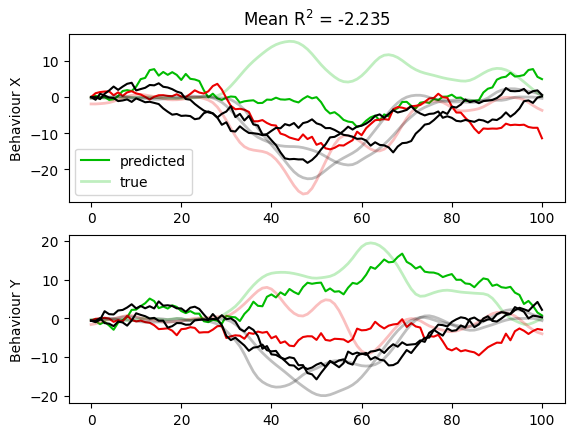

In [14]:
colors = plt.cm.nipy_spectral(np.arange(8)/8)

train_directions = data['train_target_direction']
unique_dirs = sorted(set(train_directions))
assert len(unique_dirs) == 8
train_direction_index = [unique_dirs.index(i) for i in train_directions]

directions = data['valid_target_direction']
unique_dirs = sorted(set(directions))
assert len(unique_dirs) == 8
direction_index = [unique_dirs.index(i) for i in directions]

predictions = []
for trial in range(data['valid_recon_data'].shape[0]):
    predictions.append(model.predict(data['valid_recon_data'][trial])[0])
predictions = np.array(predictions)

R2 = np.empty((len(unique_dirs))) # directions
for i,d in enumerate(unique_dirs):
  precision_error = (predictions[directions==d] - data['valid_behavior'][directions==d])**2
  total_variance = (data['valid_behavior'][:][directions==d] - data['valid_behavior'][directions==d].mean(0))**2+1e-6
  R2[i] = 1 - precision_error.sum()/total_variance.sum() # sum over trials and time and space

precision_error = (predictions - data['valid_behavior'][:])**2
total_variance = (data['valid_behavior'][:] - data['valid_behavior'][:].mean(0))**2+1e-6
R2_all = 1 - precision_error.sum()/total_variance.sum() # sum over trials and time and space

for trial in range(4,8):
    b = data['valid_behavior'][trial]
    p = predictions[trial]
    plt.subplot(2,1,1)
    plt.plot(p[:,0],'-', c=colors[direction_index[trial]], label='predicted')
    plt.plot(b[:,0], '-', c=colors[direction_index[trial]], alpha= 0.25, lw=2, label='true')
    plt.subplot(2,1,2)
    plt.plot(p[:,1],'-', c=colors[direction_index[trial]])
    plt.plot(b[:,1], '-', c=colors[direction_index[trial]], alpha= 0.25, lw=2) 
plt.subplot(2,1,1)
plt.ylabel('Behaviour X')
plt.title(f'Mean R$^2$ = {R2.mean():.3f}')
plt.legend(['predicted', 'true'])
plt.subplot(2,1,2)
plt.ylabel('Behaviour Y')
    
R2_all, R2, R2.mean()

## Predict behavior from factors using seq-to-seq Ridge regression

In [6]:
#predict factors
train_predictions = []
for trial in range(data['train_recon_data'].shape[0]):
    train_predictions.append(model.predict(data['train_recon_data'][trial])[2])

train_predictions = np.array(train_predictions)

predictions = []
for trial in range(data['valid_recon_data'].shape[0]):
    predictions.append(model.predict(data['valid_recon_data'][trial])[2])

predictions = np.array(predictions)

# train ridge regression to predict behavior from factors
from sklearn.linear_model import Ridge
X_train = train_predictions.reshape(-1,train_predictions.shape[-1])
Y_train = data['train_behavior'][:].reshape(-1,data['train_behavior'].shape[-1])
X_test = predictions.reshape(-1,predictions.shape[-1])
ridge = Ridge(alpha=1).fit(X_train, Y_train)
Y_pred = ridge.predict(X_test).reshape(data['valid_behavior'].shape)

X_train = train_predictions[...,:n_beh_factors].reshape(-1,n_beh_factors)
Y_train = data['train_behavior'][:].reshape(-1,data['train_behavior'].shape[-1])
X_test = predictions[...,:n_beh_factors].reshape(-1,n_beh_factors)
rel_ridge = Ridge(alpha=1).fit(X_train, Y_train)
rel_Y_pred = rel_ridge.predict(X_test).reshape(data['valid_behavior'].shape)

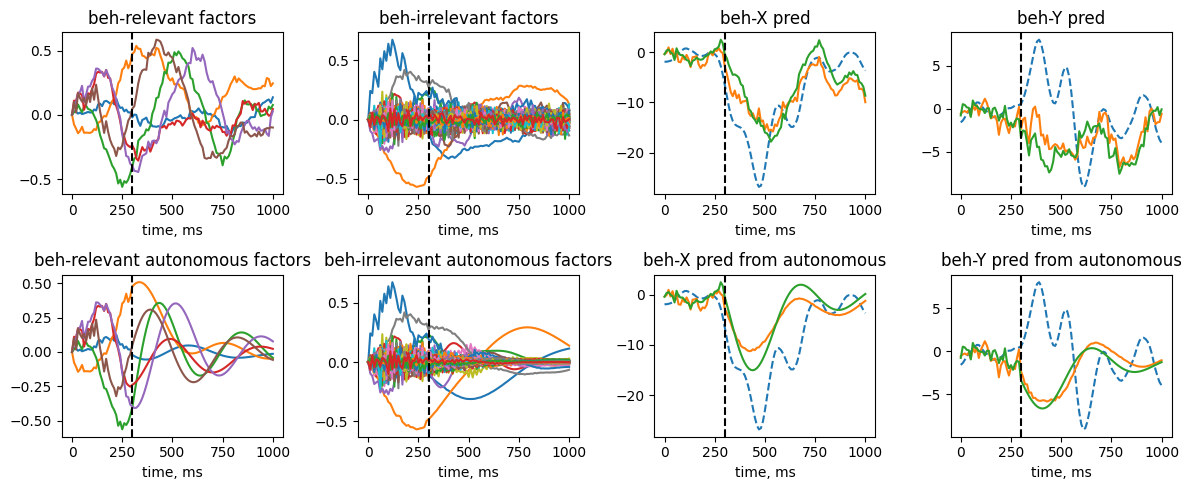

In [7]:

fig, axes = plt.subplots(2,4, figsize=(12,5))
trial = 5
axes[0,0].set_title('beh-relevant factors')
axes[0,0].plot(predictions[trial,:,:n_beh_factors])
axes[0,1].set_title('beh-irrelevant factors')
axes[0,1].plot(predictions[trial,:,n_beh_factors:])
axes[0,2].set_title('beh-X pred')
axes[0,2].plot(data['valid_behavior'][trial,:,0],linestyle='--')
axes[0,2].plot(Y_pred[trial,:,0])
axes[0,2].plot(rel_Y_pred[trial,:,0])
axes[0,3].set_title('beh-Y pred')
axes[0,3].plot(data['valid_behavior'][trial,:,1],linestyle='--')
axes[0,3].plot(Y_pred[trial,:,1])
axes[0,3].plot(rel_Y_pred[trial,:,1])

st = 30
trajectories = np.zeros_like(predictions)
trajectories[:,st] = predictions[:,st]
for i in range(st+1, trajectories.shape[1]):
    trajectories[:,i] = (model.A @ trajectories[:,i-1].T).T # transposes deal with trial dimension, tested
trajectories[:,:st] = predictions[:,:st]
axes[1,0].set_title('beh-relevant autonomous factors')
axes[1,0].plot(trajectories[trial,:,:n_beh_factors])
axes[1,1].set_title('beh-irrelevant autonomous factors')
axes[1,1].plot(trajectories[trial,:,n_beh_factors:])

Y_autonomous_pred = ridge.predict(trajectories.reshape(-1,trajectories.shape[-1])).reshape(data['valid_behavior'].shape)
rel_Y_autonomous_pred = rel_ridge.predict(trajectories[...,:n_beh_factors].reshape(-1,n_beh_factors)).reshape(data['valid_behavior'].shape)
axes[1,2].set_title('beh-X pred from autonomous')
axes[1,2].plot(data['valid_behavior'][trial,:,0],linestyle='--')
axes[1,2].plot(Y_autonomous_pred[trial,:,0])
axes[1,2].plot(rel_Y_autonomous_pred[trial,:,0])
axes[1,3].set_title('beh-Y pred from autonomous')
axes[1,3].plot(data['valid_behavior'][trial,:,1],linestyle='--')
axes[1,3].plot(Y_autonomous_pred[trial,:,1])
axes[1,3].plot(rel_Y_autonomous_pred[trial,:,1])

for ax in axes.flatten():
    ax.axvline(st, color='k', linestyle='--')
    ax.set_xlabel('time, ms')
    ax.set_xticks([0,25,50,75,100])
    ax.set_xticklabels([0,250,500,750,1000])

plt.tight_layout()

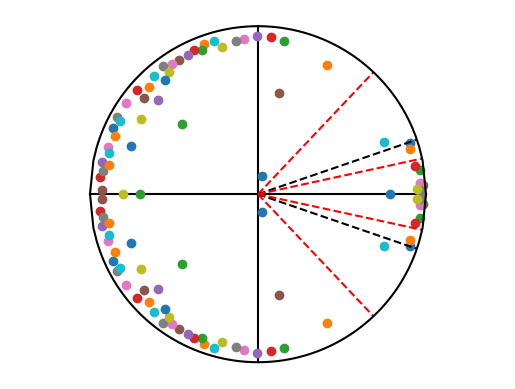

In [8]:
plot_eigenspectrum(model.A);

In [9]:
# get angles of eigenvalues
evals, evecs = np.linalg.eig(model.A)
angles = np.angle(evals)
distance_from_oscillatory = (angles - 2 * 10 * np.pi/tT) % (2*np.pi)
which_eval = np.where((np.abs(distance_from_oscillatory) < 2 * 10 * np.pi/dt) & (np.sqrt(evals.real**2 + evals.imag**2)>0.5))[0]

oscillatory_evec = evecs[which_eval].T
oscillatory_evec.shape

(100, 2)

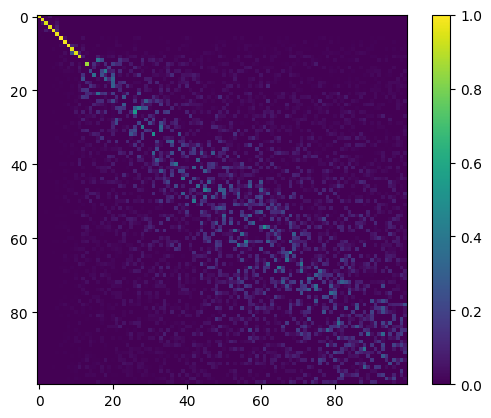

In [10]:
plt.imshow(model.A, vmin=0, vmax=1)
plt.colorbar()

## Q0: how many factors to predict direction of movement?

In [28]:
Fs = [2,5,10,20,50]

for i, n_beh_factors in enumerate(Fs):

        print('Running with', n_beh_factors, '/', n_beh_factors, 'factors')
        model = PSID.PSID(
            [d for d in data["train_recon_data"][:]], [d for d in data["train_behavior"][:]], 
            n_beh_factors, n_beh_factors, max(10, int(np.ceil(n_beh_factors/2)))
        )

        predictions = []
        for trial in range(data['valid_recon_data'].shape[0]):
            predictions.append(model.predict(data['valid_recon_data'][trial])[0])
        predictions = np.array(predictions)  

        # classify by final position
        class_acc_fp = class_accuracy(np.sum(data['train_behavior'][:],1), train_direction_index,
                                    np.sum(predictions,1), direction_index)
        print('Final position classification accuracy:', class_acc_fp)

        # classify by position at any given moment
        start_t = 50
        class_acc = class_accuracy(np.cumsum(data['train_behavior'][:],axis=1)[:,start_t:].reshape(-1,2),
                                np.array(train_direction_index).reshape(1,-1).repeat(data['train_behavior'].shape[1]-start_t,0).T.reshape(-1),
                                np.cumsum(predictions,axis=1)[:,start_t:].reshape(-1,2),
                                np.array(direction_index).reshape(1,-1).repeat(data['valid_behavior'].shape[1]-start_t,0).T.reshape(-1))
        print('Position classification accuracy:', class_acc)
        

Running with 2 / 2 factors
Final position classification accuracy: 0.7758620689655172
Position classification accuracy: 0.6827248140635565
Running with 5 / 5 factors
Final position classification accuracy: 0.853448275862069
Position classification accuracy: 0.7866801893171061
Running with 10 / 10 factors
Final position classification accuracy: 0.8189655172413793
Position classification accuracy: 0.8069641649763354
Running with 20 / 20 factors
Final position classification accuracy: 0.8448275862068966
Position classification accuracy: 0.8056118999323868
Running with 50 / 50 factors
Final position classification accuracy: 0.8275862068965517
Position classification accuracy: 0.7882014874915484
Running with 100 / 100 factors
Could not solve DARE: The associated symplectic pencil has eigenvalues too close to the unit circle


/disk/scratch2/nkudryas/micromamba/envs/band-torch/lib/python3.9/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Final position classification accuracy: 0.1206896551724138
Position classification accuracy: 0.10209601081812035


Misclassified trial #: 13 out of 116


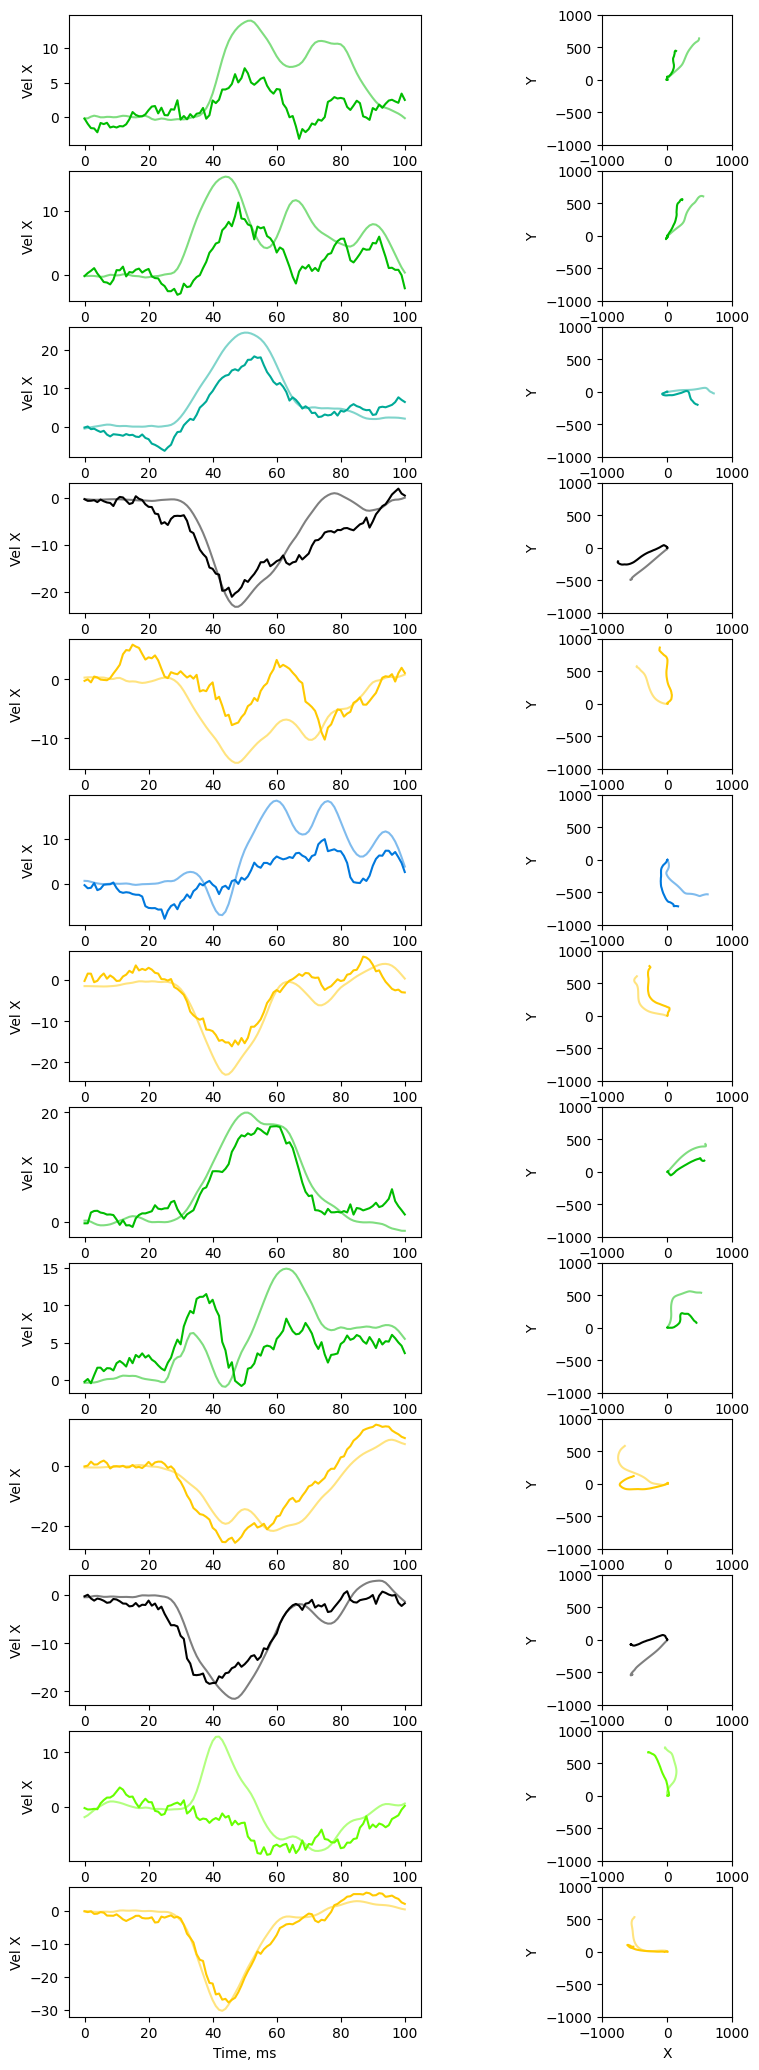

In [36]:
#plot behavior in misclassified trials
n_factors, n_beh_factors = 100, 40
model = PSID.PSID(
            [d for d in data["train_recon_data"][:]], [d for d in data["train_behavior"][:]], 
            n_factors, n_beh_factors, max(10, int(np.ceil(n_beh_factors/2)))
        )

predictions = []
for trial in range(data['valid_recon_data'].shape[0]):
    predictions.append(model.predict(data['valid_recon_data'][trial])[0])
predictions = np.array(predictions)  

# classify by final position
y_train, dir_index_train = np.sum(data['train_behavior'][:],1), train_direction_index
y_pred, dir_index = np.sum(predictions,1), direction_index
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(y_train, dir_index_train)
lda_dir = lda.predict(y_pred)
misclassified = np.where(lda_dir != dir_index)[0]
print('Misclassified trial #:', len(misclassified), 'out of', len(dir_index))

fig, axes = plt.subplots(len(misclassified),2, figsize=(10,2*len(misclassified)))
for i, trial in enumerate(misclassified):
    axes[i,0].plot(predictions[trial,:,0],'-', c=colors[direction_index[trial]])
    axes[i,0].plot(data['valid_behavior'][trial,:,0],'-', c=colors[direction_index[trial]], alpha=0.5)

    axes[i,1].plot(*np.cumsum(predictions[trial],axis=0).T,'-', c=colors[direction_index[trial]])
    axes[i,1].plot(*np.cumsum(data['valid_behavior'][trial],axis=0).T,'-', c=colors[direction_index[trial]], alpha=0.5)

    axes[i,0].set_ylabel('Vel X')
    axes[i,1].set_ylabel('Y')
    axes[i,0].set_xlabel('Time, ms')
    axes[i,1].set_xlabel('X')


    axes[i,1].set_ylim(-1000,1000)
    axes[i,1].set_xlim(-1000,1000)
    axes[i,1].set_aspect('equal')



## Q1: how many beh-relevant factors are needed to predict oscillations (no irrelevant)?

Change mask to train on AD only or all epochs

In [31]:
Fs = [2,3,4,5,6,7,8,9]
eigenvalues = np.empty((len(Fs)), dtype=object)
potentially_oscillatory_eigenvalues = np.empty((len(Fs)), dtype=object)
first_oscillatory_model = None
for i, n_beh_factors in enumerate(Fs):

        if eigenvalues[i] is None:
            
            print('Running with', n_beh_factors, '/', n_beh_factors, 'factors')
            # mask = data['train_epoch'][:] == 1 # train on the AD epoch only
            mask = data['train_epoch'][:] >= 0 # train on all
            model = PSID.PSID(
                [d for d in data["train_recon_data"][mask]], [d for d in data["train_behavior"][mask]], 
                n_beh_factors, n_beh_factors, max(10, int(np.ceil(n_beh_factors/2)))
            )

            evals = np.linalg.eig(model.A)[0]

            interesting_evals = []
            for eval in evals:
                a = np.angle(eval)
                if oscillatory_criterion(a):
                    T = 2 * 10 * np.pi / a
                    amp = np.linalg.norm(eval)
                    print(T,amp)
                    interesting_evals.append(eval)

                    if first_oscillatory_model is None:
                        first_oscillatory_model = model

            eigenvalues[i] = evals
            potentially_oscillatory_eigenvalues[i] = interesting_evals
        

Running with 2 / 2 factors
Running with 3 / 3 factors
Running with 4 / 4 factors
Running with 5 / 5 factors
Running with 6 / 6 factors
254.12599987692468 0.9404733540565852
Running with 7 / 7 factors
196.87217904543795 0.9500408245296164
Running with 8 / 8 factors
195.42135214594921 0.9609924748608061
239.75618438378734 0.9051210721673939
Running with 9 / 9 factors
157.44003429587366 0.9593281018090563
231.06272136286145 0.9095091140857654


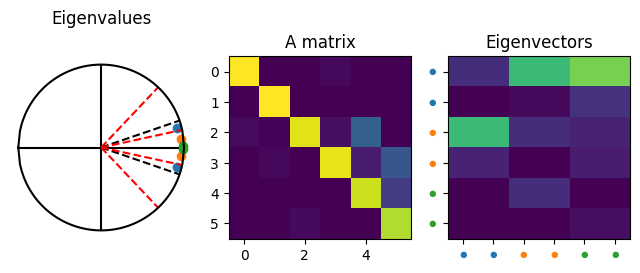

In [30]:
only_rel_model = first_oscillatory_model
plot_model_summary(only_rel_model)


## Q2: how many beh-irrelevant factors are needed to predict oscillations (no relevant, =Kalman)?

Change mask to train on AD only or all epochs

In [35]:
# Fs = [2,3,4,5,6,7,8,9]
Fs = [15,16,17]
eigenvalues = np.empty((len(Fs)), dtype=object)
potentially_oscillatory_eigenvalues = np.empty((len(Fs)), dtype=object)
first_oscillatory_model = None
for i, n_factors in enumerate(Fs):

        if eigenvalues[i] is None:
            
            print('Running with', 0, '/', n_factors, 'factors')
            # mask = data['train_epoch'][:] == 1 # train on the AD epoch only
            mask = data['train_epoch'][:] >= 0 # train on all
            model = PSID.PSID(
                [d for d in data["train_recon_data"][mask]], [d for d in data["train_behavior"][mask]], 
                n_factors, 0, 10
            )

            evals = np.linalg.eig(model.A)[0]

            interesting_evals = []
            for eval in evals:
                a = np.angle(eval)
                if oscillatory_criterion(a):
                    T = 2 * 10 * np.pi / a
                    amp = np.linalg.norm(eval)
                    print(T,amp)
                    interesting_evals.append(eval)

                    if first_oscillatory_model is None:
                        first_oscillatory_model = model

            eigenvalues[i] = evals
            potentially_oscillatory_eigenvalues[i] = interesting_evals
        

Running with 0 / 15 factors
Running with 0 / 16 factors
Running with 0 / 17 factors
284.12084310255756 0.9143575647289036


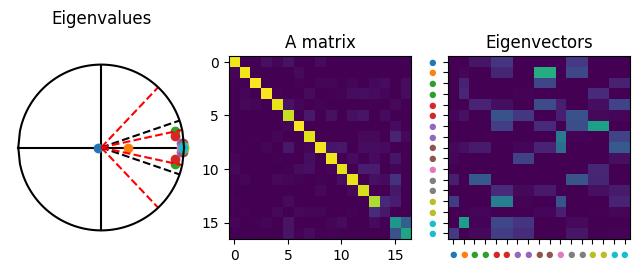

In [36]:
only_irrel_model = first_oscillatory_model
plot_model_summary(only_irrel_model)

# Number of beh-relevant factors for the best R2

(116, 101, 2)
30 0.786629312698188
(116, 101, 2)
35 0.8025614602178358
(116, 101, 2)
37 0.8054148826138714
(116, 101, 2)
38 0.8051223325463099
(116, 101, 2)
39 0.8075940271612019
(116, 101, 2)
40 0.8075414190543515
(116, 101, 2)
41 0.8069423557817721
(116, 101, 2)
42 0.8078999852909605
(116, 101, 2)
43 0.8035228387703497
(116, 101, 2)
45 0.8031250910300536
(116, 101, 2)
50 0.8035855115676035


42

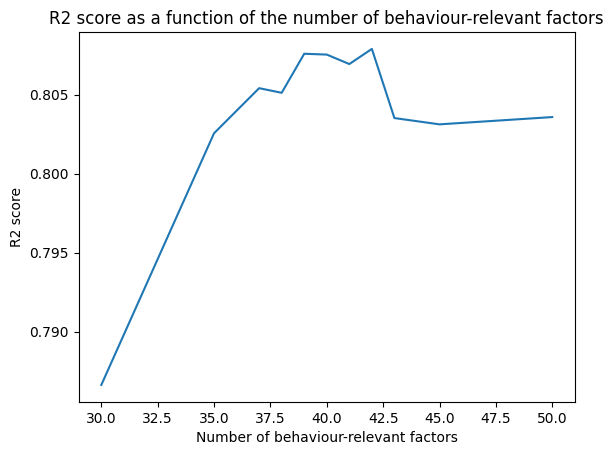

In [44]:
n_factors = 100

ns = [30, 35, 37, 38, 39, 40, 41, 42, 43, 45, 50]
r2s = []
for n_beh_factors in ns: 

    model = PSID.PSID(
                    [d for d in data["train_recon_data"][mask]], [d for d in data["train_behavior"][mask]], 
                    n_factors, n_beh_factors, max(10, int(np.ceil(n_beh_factors/2)))
                )

    predictions = []
    for trial in range(data['valid_recon_data'].shape[0]):
        predictions.append(model.predict(data['valid_recon_data'][trial])[0])

    predictions = np.array(predictions)
    print(predictions.shape)

    r2 = r2_score(predictions, data['valid_behavior'][:])

    print(n_beh_factors, r2)
    r2s.append(r2)

plt.plot(ns, r2s)
plt.xlabel('Number of behaviour-relevant factors')
plt.ylabel('R2 score')
plt.title('R2 score as a function of the number of behaviour-relevant factors')

# best n
n_beh_factors = ns[np.argmax(r2s)]
n_beh_factors


# Lags

In [37]:
n_factors = 100
n_beh_factors = 20

max_lag=10
min_lag=10
aug_train_behavior = [data["train_behavior"][mask][:,min_lag+lag:-max_lag+lag] for lag in range(-min_lag,max_lag)] + [data["train_behavior"][mask][:,min_lag+max_lag:]]
aug_train_behavior = np.concatenate(aug_train_behavior,axis=-1)
print(aug_train_behavior.shape)

model = PSID.PSID(
    [d for d in data["train_recon_data"][mask][:,min_lag:-max_lag]], [d for d in aug_train_behavior], 
    n_factors, n_beh_factors, 10
)


(465, 81, 42)


In [ ]:

#predict factors
train_predictions = []
for trial in range(data['train_recon_data'].shape[0]):
    train_predictions.append(model.predict(data['train_recon_data'][trial])[2])

train_predictions = np.array(train_predictions)

predictions = []
for trial in range(data['valid_recon_data'].shape[0]):
    predictions.append(model.predict(data['valid_recon_data'][trial])[2])

predictions = np.array(predictions)

# train ridge regression to predict behavior from factors
from sklearn.linear_model import Ridge
X_train = train_predictions.reshape(-1,train_predictions.shape[-1])
Y_train = data['train_behavior'][:].reshape(-1,data['train_behavior'].shape[-1])
X_test = predictions.reshape(-1,predictions.shape[-1])
ridge = Ridge(alpha=1).fit(X_train, Y_train)
Y_pred = ridge.predict(X_test).reshape(data['valid_behavior'].shape)

X_train = train_predictions[...,:n_beh_factors].reshape(-1,n_beh_factors)
Y_train = data['train_behavior'][:].reshape(-1,data['train_behavior'].shape[-1])
X_test = predictions[...,:n_beh_factors].reshape(-1,n_beh_factors)
rel_ridge = Ridge(alpha=1).fit(X_train, Y_train)
rel_Y_pred = rel_ridge.predict(X_test).reshape(data['valid_behavior'].shape)

In [ ]:
lags = range(-7,7)
for epoch in [0,1,2]:
    c = []
    for lag in lags:
        beh = np.roll(data['valid_behavior'],lag,axis=1)
        mask = data['valid_epoch'][:] == epoch
        c.append(np.corrcoef(beh[mask][:,st:].flatten(),Y_pred[mask][:,st:].flatten())[0,1])
    plt.plot(lags,c)
plt.axvline(0)

In [ ]:
from lfads_torch.metrics import r2_score

def lagged_r2s(x_train, x_test, true_train_beh, true_valid_beh, max_lag = 25):
    lags = np.arange(-max_lag,max_lag+1)
    r2s = []
    for lag in lags:
        # ridge regression between lagged factors and behavior
        if lag==max_lag:
            X_train = x_train[:,max_lag+lag:].reshape(-1,x_train.shape[-1])
            X_test = x_test[:,max_lag+lag:].reshape(-1,x_test.shape[-1])
        else:
            X_train = x_train[:,max_lag+lag:-max_lag+lag].reshape(-1,x_train.shape[-1])
            X_test = x_test[:,max_lag+lag:-max_lag+lag].reshape(-1,x_test.shape[-1])

        Y_train = true_train_beh[:,max_lag:-max_lag].reshape(-1,true_train_beh.shape[-1])
        ridge = Ridge(alpha=1).fit(X_train, Y_train)
        Y_pred = ridge.predict(X_test).reshape(true_valid_beh[:,max_lag:-max_lag].shape)
        r2 = r2_score(Y_pred, true_valid_beh[:,max_lag:-max_lag])
        r2s.append(r2)
    return -lags*10, r2s

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(15,2),sharey=True)
for epoch, epoch_name in enumerate(['BL','AD','W0']):
   
   lag_r2 = lagged_r2s(train_predictions[:,:,:n_beh_factors][data['train_epoch'][:] == epoch],
                        predictions[:,:,:n_beh_factors][data['valid_epoch'][:] == epoch],
                        data['train_behavior'][:][data['train_epoch'][:] == epoch],
                        data['valid_behavior'][:][data['valid_epoch'][:] == epoch])
   axes[0].plot(*lag_r2)
   id_max = np.argmax(lag_r2[1])
   axes[0].scatter(lag_r2[0][id_max],lag_r2[1][id_max],label=f'{epoch_name}: {lag_r2[0][id_max]} ms')

   axes[1].plot(*lagged_r2s(train_predictions[:,:,n_beh_factors:][data['train_epoch'][:] == epoch],
                        predictions[:,:,n_beh_factors:][data['valid_epoch'][:] == epoch],
                        data['train_behavior'][:][data['train_epoch'][:] == epoch],
                        data['valid_behavior'][:][data['valid_epoch'][:] == epoch],), 
   )

#    axes[2].plot(*lagged_r2s((train_predictions[:]@oscillatory_evec.real)[data['train_epoch'][:] == epoch],
#                         (predictions[:]@oscillatory_evec.real)[data['valid_epoch'][:] == epoch],
#                         data['train_behavior'][:][data['train_epoch'][:] == epoch],
#                         data['valid_behavior'][:][data['valid_epoch'][:] == epoch]), 
#    )

   lag_r2 = lagged_r2s(train_predictions[:,:,:][data['train_epoch'][:] == epoch],
                        predictions[:,:,:][data['valid_epoch'][:] == epoch],
                        data['train_behavior'][:][data['train_epoch'][:] == epoch],
                        data['valid_behavior'][:][data['valid_epoch'][:] == epoch])
   axes[2].plot(*lag_r2)
   id_max = np.argmax(lag_r2[1])
   axes[2].scatter(lag_r2[0][id_max],lag_r2[1][id_max],label=f'{epoch_name}: {lag_r2[0][id_max]} ms')

for ax in axes:
      ax.set_xlabel('lag, ms')
      ax.set_ylabel('R2')
      ax.axvline(0, color='k', linestyle='--')
      ax.set_ylim([0.7,0.95])
axes[0].set_title('beh-relevant factors')
axes[1].set_title('beh-irrelevant factors') 
axes[2].set_title('all factors')
axes[0].legend()
axes[2].legend()

## run models with various lags

In [ ]:
from tqdm import tqdm

def run_lagged_r2s(x_train, x_test, true_train_beh, true_valid_beh, max_lag = 25, n_factors = 40, n_beh_factors = 20):
    lags = np.arange(-max_lag,max_lag+1)
    rel_r2s, irrel_r2s = [], []
    for lag in tqdm(lags):

        neural = x_train[:,max_lag+lag:] if lag==max_lag else x_train[:,max_lag+lag:-max_lag+lag]
        neural_test = x_test[:,max_lag+lag:] if lag==max_lag else x_test[:,max_lag+lag:-max_lag+lag]
        behavioral = true_train_beh[:,max_lag:-max_lag]
        behavioral_test = true_valid_beh[:,max_lag:-max_lag]
        model = PSID.PSID(
            [d for d in neural], [d for d in behavioral], 
            n_factors, n_beh_factors, 10
        )
        #predict factors
        train_predictions = np.array([model.predict(a)[2] for a in neural])
        predictions = np.array([model.predict(a)[2] for a in neural_test])

        # ridge regression between lagged factors and behavior
        X_train = train_predictions[:,:,:n_beh_factors].reshape(-1,n_beh_factors)
        X_test = predictions[:,:,:n_beh_factors].reshape(-1,n_beh_factors)

        Y_train = behavioral.reshape(-1,true_train_beh.shape[-1])
        ridge = Ridge(alpha=1).fit(X_train, Y_train)
        Y_pred = ridge.predict(X_test).reshape(behavioral_test.shape)
        r2 = r2_score(Y_pred, behavioral_test)
        rel_r2s.append(r2)

        # ridge regression between lagged factors and behavior
        X_train = train_predictions[:,:,n_beh_factors:].reshape(-1,n_factors - n_beh_factors)
        X_test = predictions[:,:,n_beh_factors:].reshape(-1,n_factors - n_beh_factors)

        Y_train = behavioral.reshape(-1,true_train_beh.shape[-1])
        ridge = Ridge(alpha=1).fit(X_train, Y_train)
        Y_pred = ridge.predict(X_test).reshape(behavioral_test.shape)
        r2 = r2_score(Y_pred, behavioral_test)
        irrel_r2s.append(r2)
    return -lags*10, rel_r2s, irrel_r2s

lags2plot, rel_r2s, irrel_r2s = run_lagged_r2s(data["train_recon_data"][data['train_epoch'][:] == 1],
                                                data["valid_recon_data"][data['valid_epoch'][:] == 1],
                                                data["train_behavior"][data['train_epoch'][:] == 1],
                                                data["valid_behavior"][data['valid_epoch'][:] == 1],
                                                n_factors = 40, n_beh_factors = 20)

fig, axes = plt.subplots(1,2, figsize=(10,2),sharey=True)
axes[0].plot(lags2plot, rel_r2s)
axes[1].plot(lags2plot, irrel_r2s)
for ax in axes:
    ax.set_xlabel('lag, ms')
    ax.set_ylabel('R2')
    ax.axvline(0, color='k', linestyle='--')
axes[0].set_title('beh-relevant factors')
axes[1].set_title('beh-irrelevant factors')

In [ ]:
for epoch in [0,2]:
    lags2plot[epoch], rel_r2s[epoch], irrel_r2s[epoch] = run_lagged_r2s(data["train_recon_data"][data['train_epoch'][:] == epoch],
                                                                        data["valid_recon_data"][data['valid_epoch'][:] == epoch],
                                                                        data["train_behavior"][data['train_epoch'][:] == epoch],
                                                                        data["valid_behavior"][data['valid_epoch'][:] == epoch],
                                                                        n_factors = 40, n_beh_factors = 20)


In [ ]:
    
fig, axes = plt.subplots(1,2, figsize=(10,2),sharey=True)
for epoch in range(3):
    axes[0].plot(lags2plot[epoch], rel_r2s[epoch])
    axes[1].plot(lags2plot[epoch], irrel_r2s[epoch])
for ax in axes:
    ax.set_xlabel('lag, ms')
    ax.set_ylabel('R2')
    ax.axvline(0, color='k', linestyle='--')
    # ax.set_xlim([-100,100])
axes[0].set_title('beh-relevant factors')
axes[1].set_title('beh-irrelevant factors')
plt.legend(['BL','AD','WO'])


In [ ]:


fig, axes = plt.subplots(1,2, figsize=(10,2))
axes[0].plot(lags2plot, rel_r2s)
axes[1].plot(lags2plot, irrel_r2s)
for ax in axes:
    ax.set_xlabel('lag, ms')
    ax.set_ylabel('R2')
    ax.axvline(0, color='k', linestyle='--')
axes[0].set_title('beh-relevant factors')
axes[1].set_title('beh-irrelevant factors')